In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pareto
import abc
from tqdm import tqdm

In [3]:
c_scale = 10
def mu(x, y):
    x1, x2 = 4*x - 2, 4*y - 2
    v1 = 1 + (x1 + x2 + 1)**2 * \
        (19 - 14*x1 + 3*x1**2 - 14*x2 + 6*x1*x2 + 3*x2**2)
    v2 = 30 + (2*x1 - 3*x2)**2 * \
        (18 - 32*x1 + 12*x1**2 + 48*x2 - 36*x1*x2 + 27*x2**2)
    reward = v1 * v2
    reward = (np.log(v1 * v2) - 8.693 ) / c_scale
#     observation = np.random.normal(reward, 0.1)
    return reward

In [4]:
delta = 1e-3
from itertools import product
linspace = np.linspace(0,1,1000)
arms = list(product(linspace, repeat=2))
fun_values = []
for arm in arms:
    fun_values.append(mu(arm[0], arm[1]))
fun_values = np.array(fun_values)
mu_m_delta = np.quantile(fun_values, 1-delta)
mu_m = np.max(fun_values)
# mu_m_delta_scale = mu_m_delta
# mu_m_scale = mu_m
mu_m_delta_scale = np.exp(mu_m_delta * c_scale + 8.693)
mu_m_scale = np.exp(mu_m * c_scale + 8.693)


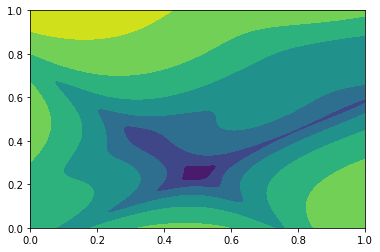

In [5]:
x = np.linspace(0, 1, 1000)
y = np.linspace(0, 1, 1000)
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, mu(X, Y))
plt.show()

In [6]:
def sample(x, y):
    return np.random.uniform(x, y)


def get_uncovered_2d(arm, r):
    xgrid = [0, 1]
    ygrid = [0, 1]
    
    for aa, rr in zip(arm,  r):
        xgrid.append(max(aa[0] - rr, 0))
        xgrid.append(min(aa[0] + rr, 1))
        ygrid.append(max(aa[1] - rr, 0))
        ygrid.append(min(aa[1] + rr, 1))
    
    xgrid = sorted(list(set(xgrid)))
    ygrid = sorted(list(set(ygrid)))
    
    partition = np.zeros((len(xgrid) - 1, len(ygrid) - 1))
    for central, radious in zip(arm, r):
        x_b = 0
        x_e = 0
        y_b = 0
        y_e = 0
        for i in range(len(xgrid)):
            if xgrid[i] == max(central[0] - radious, 0):
                x_b = i
                break
        for i in range(len(xgrid) - 1, -1, -1):
            if xgrid[i] == min(central[0] + radious, 1):
                x_e = i
                break
        for i in range(len(ygrid)):
            if ygrid[i] == max(central[1] - radious, 0):
                y_b = i
                break
        for i in range(len(ygrid)):
            if ygrid[i] == min(central[1] + radious, 1):
                y_e = i
                break
        for i in range(x_b, x_e, 1):
            for j in range(y_b, y_e, 1):
                partition[i][j] = 1
                
    for i in range(len(xgrid) - 1):
        for j in range (len(ygrid) - 1):
            if partition[i][j] == 0:
                return (sample(xgrid[i], xgrid[i+1]), sample(ygrid[j], ygrid[j+1]))
#                 return ((xgrid[i] + xgrid[i + 1]) / 2, (ygrid[j] + ygrid[j + 1]) / 2)
    return None

In [7]:
class Algorithm(metaclass=abc.ABCMeta):  # abstract class of `Algorithm`
    def __init__(self, delta, T, c):
        self.delta = delta
        self.T = T
        self.c = c
        self.pulled_idx = None
        self.active_arms = None
        self.mu = None
        self.n = None
        self.r = None

    @abc.abstractmethod
    def initialize(self):
        pass

    @abc.abstractmethod
    def output(self):
        pass

    @abc.abstractmethod
    def observe(self, t, y):
        pass

    def get_uncovered(self):
        return get_uncovered_2d(self.active_arms, self.r)

In [8]:
class Zooming(Algorithm):
    def __init__(self, delta, T, c, nu):
        super().__init__(delta, T, c)
        self.nu = nu

    def initialize(self):
        self.active_arms = []
        self.mu = []
        self.n = []
        self.r = []

    def output(self):
        uncovered = self.get_uncovered()
        if uncovered is None:
            score = [mu + 2 * r for mu, r in zip(self.mu, self.r)]
            self.pulled_idx = np.argmax(score)
        else:
            new_arm = uncovered
            self.active_arms.append(new_arm)
            self.mu.append(0)
            self.n.append(0)
            self.r.append(0)
            self.pulled_idx = len(self.active_arms) - 1
        return self.pulled_idx

    def observe(self, T, y):
        idx = self.pulled_idx
        self.mu[idx] = (self.mu[idx] * self.n[idx] + y) / (self.n[idx] + 1)
        self.n[idx] += 1
        for i, n in enumerate(self.n):
            self.r[i] = self.c * np.log(T**2/0.01)*np.sqrt(np.log(T**2/0.01) / (n + 1))

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

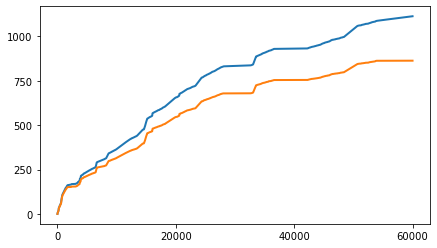

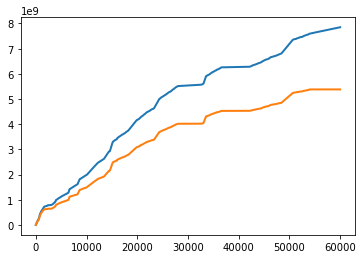

 10%|████████▏                                                                         | 1/10 [02:29<22:23, 149.33s/it]

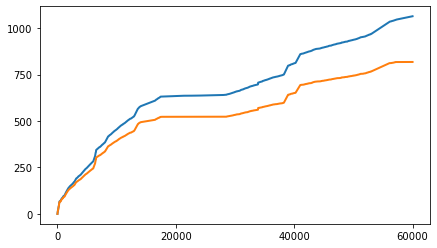

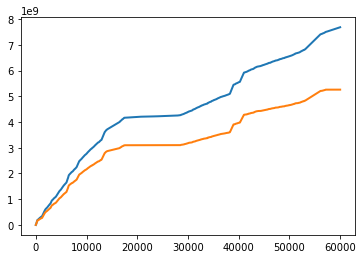

 20%|████████████████▍                                                                 | 2/10 [04:35<18:04, 135.61s/it]

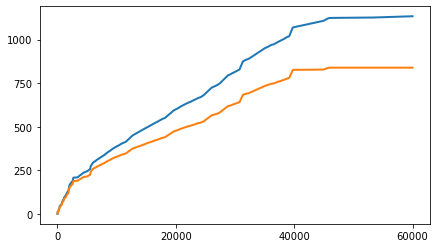

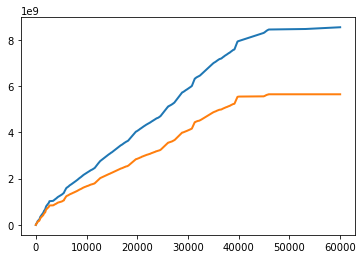

 30%|████████████████████████▌                                                         | 3/10 [06:38<15:09, 129.93s/it]

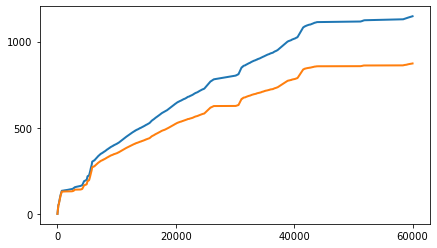

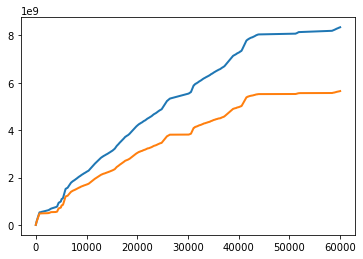

 40%|████████████████████████████████▊                                                 | 4/10 [09:08<13:47, 137.94s/it]

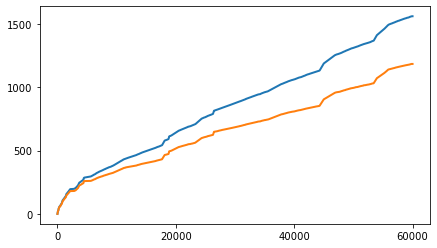

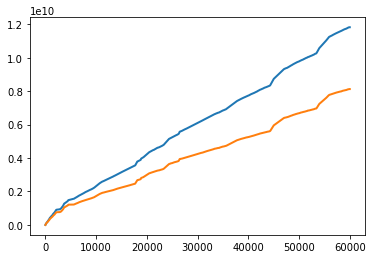

 50%|█████████████████████████████████████████                                         | 5/10 [11:29<11:34, 138.88s/it]

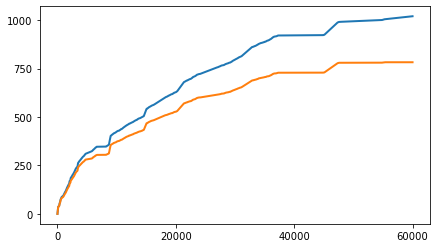

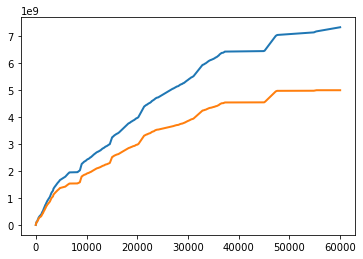

 60%|█████████████████████████████████████████████████▏                                | 6/10 [13:48<09:15, 138.96s/it]

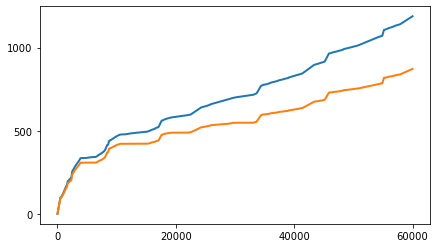

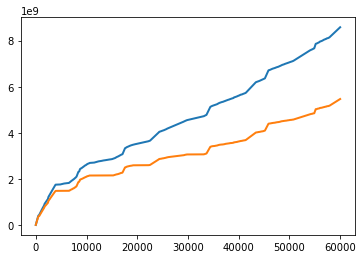

 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [16:36<07:25, 148.48s/it]

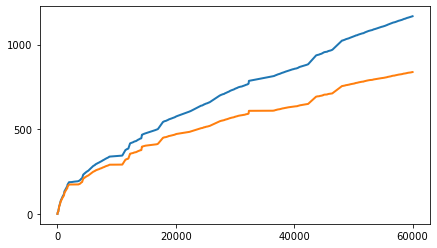

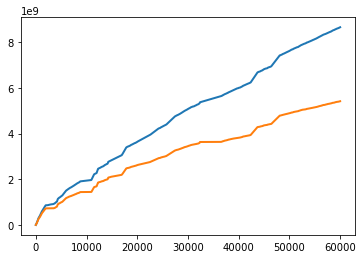

 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [18:52<04:49, 144.54s/it]

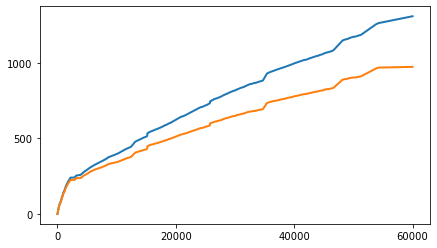

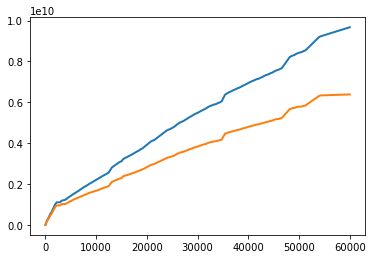

 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [21:04<02:20, 140.45s/it]

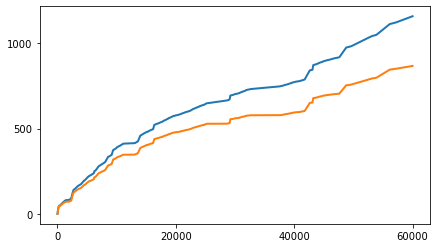

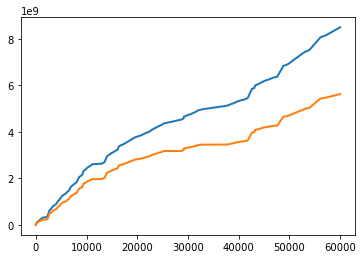

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [22:58<00:00, 137.85s/it]


In [10]:
def simulate(algorithms, a, alpha, T, trials):
    cum_regret = np.zeros((len(algorithms), T + 1))

    cum_regret_scale = np.zeros((len(algorithms), T + 1)) #---------
    
    cum_regret_delta = np.zeros((len(algorithms), T + 1))
    
    cum_regret_delta_scale = np.zeros((len(algorithms), T + 1))

    total_arm = 0
    for trial in range(trials):
        inst_regret = np.zeros((len(algorithms), T + 1))

        inst_regret_scale = np.zeros((len(algorithms), T + 1)) #---------
        
        inst_regret_delta = np.zeros((len(algorithms), T + 1))
        
        inst_regret_delta_scale = np.zeros((len(algorithms), T + 1))

        for alg in algorithms:
            alg.initialize()

        for t in range(1, T + 1):
            for i, alg in enumerate(algorithms):
                idx = alg.output()
                arm = alg.active_arms[idx]
                #
#                 reward = mu(arm[0], arm[1])
                reward = np.exp(mu(arm[0], arm[1]) * c_scale + 8.693)
#                 print(mu(arm[0], arm[1]))
                inst_regret_scale[i, t] = max(mu_m_scale - reward, 0)
                #
                inst_regret[i, t] = max(mu_m - mu(arm[0], arm[1]), 0)
                
                inst_regret_delta[i, t] = max(mu_m_delta - mu(arm[0], arm[1]), 0)
                
                inst_regret_delta_scale[i, t] = max(mu_m_delta_scale - reward, 0)
                
                y = mu(arm[0], arm[1]) + np.random.normal(0, 0.1)
                alg.observe(T, y)
                total_arm = len(alg.active_arms)
#             print(t,' ',len(alg.active_arms))

        cum_regret += inst_regret

        cum_regret_scale += inst_regret_scale
        
        cum_regret_delta += inst_regret_delta
        
        cum_regret_delta_scale += inst_regret_delta_scale
        
        
        for alg in algorithms:
            r = alg.r
#     return [total_arm, r, cum_regret / trials, cum_regret_delta / trials]
    return [total_arm, r, cum_regret / trials, cum_regret_scale / trials, cum_regret_delta / trials, cum_regret_delta_scale / trials]


regrets_all = []
regrets_delta_all = []


for _ in tqdm(range(10)):

    a = 0
        # configure parameters of experiments
    T = 60000  
    trials = 1
    delta = 0.1
    alpha = 3.1
    epsilon = 1

    # compute upper bounds for moments of different orders
    a_hat = max(abs(a), abs(a - 0.4))
    sigma_second = max(alpha / ((alpha - 1) ** 2 * (alpha - 2)), 1 / (36 * np.sqrt(2)))
    nu_second = max(a_hat ** 2 + sigma_second, np.power(12 * np.sqrt(2), -(1 + epsilon)))
    nu_third = a_hat ** 3 + 2 * alpha * (alpha + 1) / (
            (alpha - 1) ** 3 * (alpha - 2) * (alpha - 3)) + 3 * a_hat * sigma_second


    c_zooming = 0.01  

    algorithms = [Zooming(delta, T, c_zooming, nu_third)]

    # [total, r, cum_regret, cum_regret_delta] = simulate(algorithms, a, alpha, T, trials)
    [total, r, cum_regret, cum_regret_scale, cum_regret_delta, cum_regret_delta_scale] = simulate(algorithms, a, alpha, T, trials)


    # plot figure
    plt.figure(figsize=(7, 4))
    plt.locator_params(axis='x', nbins=5)
    plt.locator_params(axis='y', nbins=5)
    names = [f'{alg.__class__.__name__}' for alg in algorithms]
    linestyles = ['-', '--', '-.']
    for result, name, linestyle in zip(cum_regret, names, linestyles):
        plt.plot(np.cumsum(result), label=name, linewidth=2.0, linestyle=linestyle)

    for result, name, linestyle in zip(cum_regret_delta, names, linestyles):
        plt.plot(np.cumsum(result), label=name, linewidth=2.0, linestyle=linestyle)


        plt.show()

    for result, name, linestyle in zip(cum_regret_scale, names, linestyles): #-------
        plt.plot(np.cumsum(result), label=name, linewidth=2.0, linestyle=linestyle) #-------

    for result, name, linestyle in zip(cum_regret_delta_scale, names, linestyles): #-------
        plt.plot(np.cumsum(result), label=name, linewidth=2.0, linestyle=linestyle) #-------

        plt.show()

    
    regrets_all.append(cum_regret_scale.reshape(-1))
    regrets_delta_all.append(cum_regret_delta_scale.reshape(-1))
    

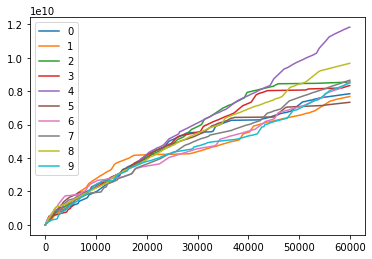

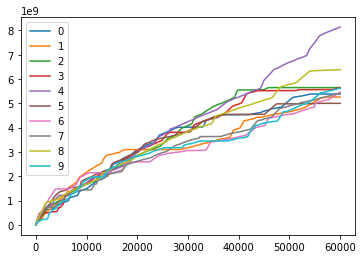

In [11]:
for i in range(10):
    plt.plot(np.cumsum(regrets_all, axis=1)[i], label='{}'.format(i))
plt.legend()
plt.show()

for i in range(10):
    plt.plot(np.cumsum(regrets_delta_all, axis=1)[i], label='{}'.format(i))
plt.legend()
plt.show()

In [12]:
regret_m = np.mean(np.cumsum(regrets_all, axis=1), axis=0)
regret_std = np.std(np.cumsum(regrets_all, axis=1), axis=0)
regret_m_delta = np.mean(np.cumsum(regrets_delta_all, axis=1), axis=0)
regret_std_delta = np.std(np.cumsum(regrets_delta_all, axis=1), axis=0)

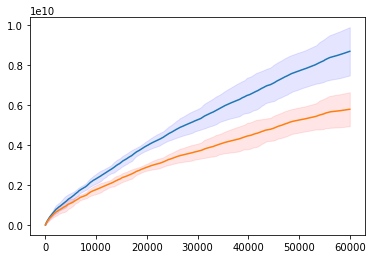

In [13]:
plt.plot(regret_m)
plt.plot(regret_m_delta)
plt.fill_between(np.array(range(len(regret_m))), 
                 regret_m - regret_std, regret_m + regret_std, alpha=0.1, color='b')
plt.fill_between(np.array(range(len(regret_m_delta))), 
                                regret_m_delta - regret_std_delta, regret_m_delta + regret_std_delta, alpha=0.1, color='r')
plt.show()

In [14]:
np.savetxt('zooming_delta.csv', regrets_delta_all)
np.savetxt('zooming.csv', regrets_all)